In [21]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import numpy as np

from constants import INPUT_SHAPE
from conversion import read_room2class, get_class2color, FloorplanRaw, FloorplanSVG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Mappings for dataset
room2class = read_room2class("room_types.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values()))

In [3]:
# Build model
n_classes = max(room2class.values())+1

# model = Sequential()

# n_filters = 64
# # Add network layers
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE))
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))


# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(Conv2DTranspose(32,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(16,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(n_classes,(5,5),padding='same', activation=tf.nn.softmax))


# # compile model
# opt = Adam(lr=0.001)
# loss = tf.keras.losses.categorical_crossentropy
# model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# model.summary()


# Simple model for testing
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(n_classes, (3, 3), padding='same', activation=tf.nn.softmax))

opt = Adam(lr=0.01)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 70)      5110      
Total params: 5,334
Trainable params: 5,334
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Build data generators
dataset_dir = "./data/cubicasa5k"
batch_size = 64


def generator(dataset_dir, txt_name, room2class, batch_size, mode="train"):
    """Generator for training data
    """
    dataset_txt = dataset_dir + txt_name
    f = open(dataset_txt, "r")
    while True:
        inputs = []
        labels = []
        while len(inputs) < batch_size:
            
            # Read next line, back from beginning if reaching end
            line = f.readline().strip()
            if not line:
                f.seek(0)
                line = f.readline().strip()
                
                #TODO: if mode is eval, do not seek to 0
            
            # Get our converted data
            data_folder = dataset_dir + line
            raw = FloorplanRaw(data_folder)
            svg = FloorplanSVG(data_folder, raw.original_shape, room2class)
            
            inputs.append(raw.image)
            labels.append(svg.semantic_map)
        
        inputs = np.array(inputs)
        labels = to_categorical(np.array(labels), num_classes=n_classes)
        yield inputs, labels


train_gen = generator(dataset_dir, "/train.txt", room2class, batch_size)
val_gen = generator(dataset_dir, "/val.txt", room2class, batch_size)

In [27]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size
num_val_images = len(open(dataset_dir + "/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size // 3
num_epochs = 1
verbose = 1

history = model.fit_generator(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    epochs=num_epochs,
                    verbose=verbose)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 2 steps
65/65 [==============================] - 1492s 23s/step - loss: 2.2445 - accuracy: 0.4694 - val_loss: 2.1980 - val_accuracy: 0.4895
CPU times: user 50min 33s, sys: 8min 40s, total: 59min 14s
Wall time: 26min 25s


No handles with labels found to put in legend.


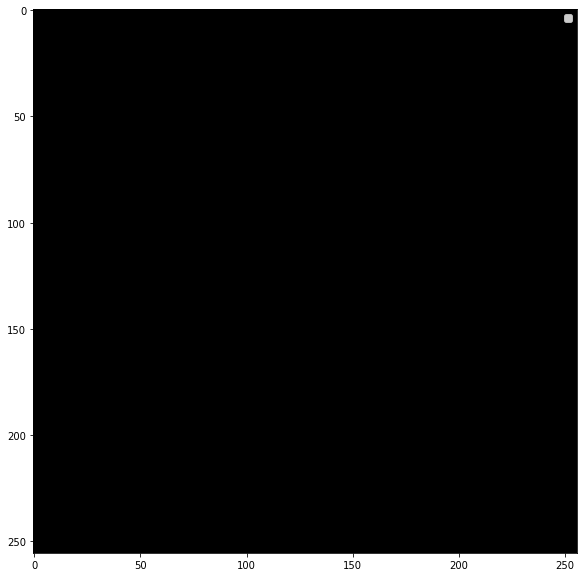

In [44]:
# Try model on an example
trial_folder = dataset_dir + "/colorful/3720/"
raw = FloorplanRaw(trial_folder)
input_img = raw.image
result = np.argmax(model.predict(np.expand_dims(input_img, axis=0)), axis=-1)[0]
FloorplanSVG.show_map(result, 0*np.ones_like(input_img), class2color, class2room)

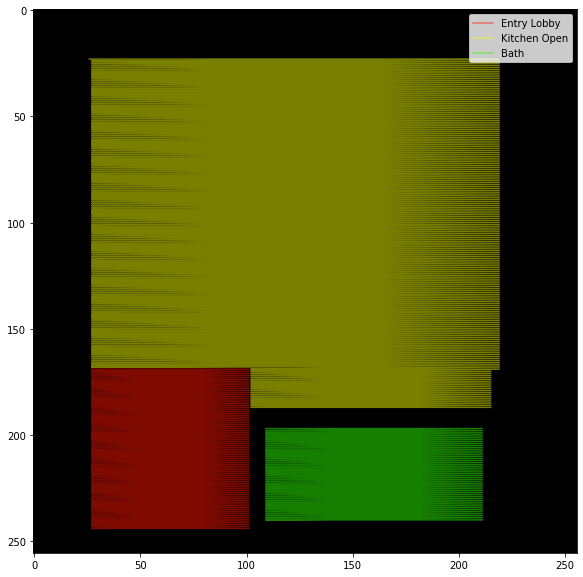

In [45]:
FloorplanSVG(trial_folder, raw.original_shape, room2class).show(0*np.ones_like(input_img), class2color, class2room)

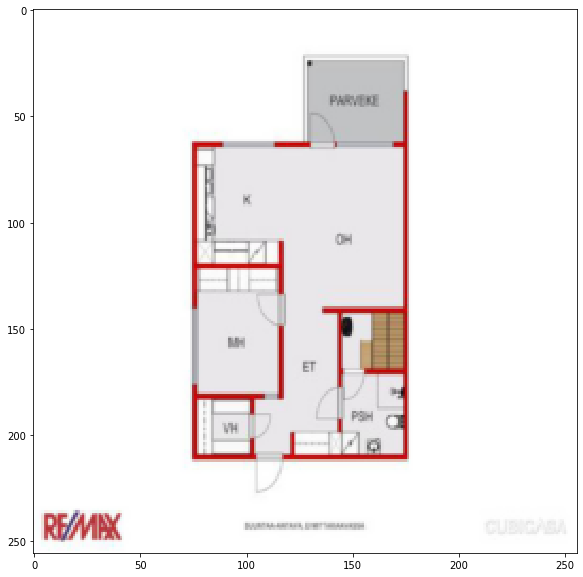

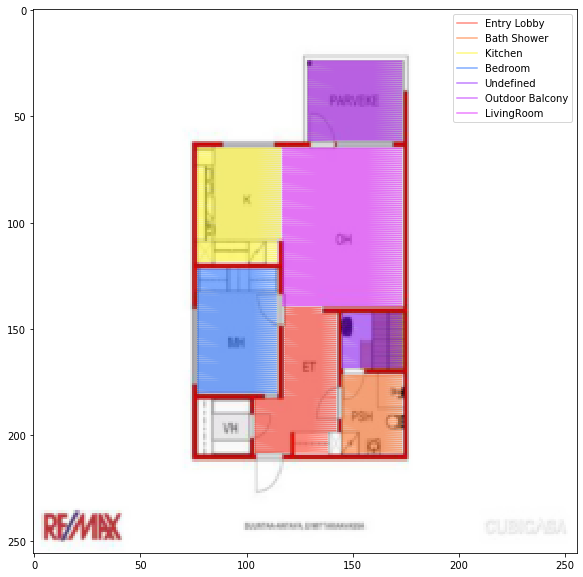

In [22]:
# Display a pair of groundtruths
trial_folder = dataset_dir + "/colorful/6327/"
raw = FloorplanRaw(trial_folder)
raw.show()
input_img = raw.image
svg = FloorplanSVG(trial_folder, raw.original_shape, room2class)
svg.show(input_img, class2color, class2room)